In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpytorch
import torch
import time
#import tikzplotlib as tpl
%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

/tmp/ipykernel_45668/2651544894.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


## Load and visualize data

In [3]:
poisson_df = pd.read_csv('poisson_sim.csv')
poisson_df

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
5,51,0,1,42
6,164,0,3,46
7,133,0,3,40
8,2,0,3,33
9,53,0,3,46


In [4]:
poisson_df.drop(columns = ['id'], inplace=True)

poisson_general_df = poisson_df[poisson_df['prog'] == 1]
poisson_academic_df = poisson_df[poisson_df['prog'] == 2]
poisson_vocational_df = poisson_df[poisson_df['prog'] == 3]

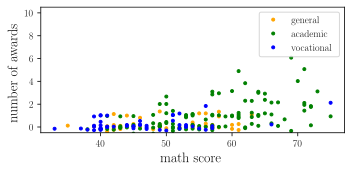

In [5]:
s = 0.2
eps1 = np.random.normal(0, 0.2, size=len(poisson_general_df))
eps2 = np.random.normal(0, 0.2, size=len(poisson_academic_df))
eps3 = np.random.normal(0, 0.2, size=len(poisson_vocational_df))

fig = plt.figure(figsize=(5, 2.5), dpi=300)
plt.ylim(-0.5, 10.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.plot(poisson_general_df['math'], poisson_general_df['num_awards']+eps1, '.', label="general", color='orange')
plt.plot(poisson_academic_df['math'], poisson_academic_df['num_awards']+eps2, '.', label="academic", color='green')
plt.plot(poisson_vocational_df['math'], poisson_vocational_df['num_awards']+eps3, '.', label="vocational", color='blue')
plt.legend()

plt.tight_layout()

plt.savefig('Poisson_all_points.pdf')

plt.show();

In [6]:
from scipy.special import gamma as gamma_func

def gamma_pdf(x, a, b):
    r = b**a/gamma_func(a) * (x ** (a-1)) * (np.exp(-x*b))
    return(r)

In [7]:
poisson_general_df[poisson_general_df['math'] == 57]

,num_awards,prog,math
40,0,1,57
87,0,1,57
99,0,1,57
160,0,1,57


In [8]:
poisson_academic_df[poisson_academic_df['math'] == 57]

,num_awards,prog,math
96,1,2,57
113,0,2,57
133,0,2,57
137,1,2,57
140,0,2,57
149,3,2,57
171,3,2,57


In [9]:
poisson_vocational_df[poisson_vocational_df['math'] == 57]

,num_awards,prog,math
103,0,3,57
115,0,3,57


## Looking at one of the marginal Gamma distributions

/tmp/ipykernel_45668/1062970641.py:4: RuntimeWarning: divide by zero encountered in power
  r = b**a/gamma_func(a) * (x ** (a-1)) * (np.exp(-x*b))


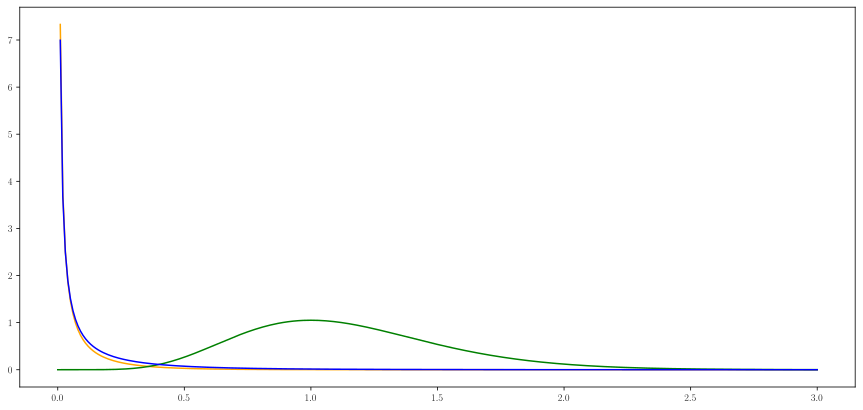

In [10]:
x = np.linspace(0, 3, 300+1)
alpha_0 = 0.1
beta_0 = 0.1

gamma_test = gamma_pdf(x, alpha_0+1, beta_0+1)

gamma_general = gamma_pdf(x, alpha_0+0, beta_0+4)
gamma_academic = gamma_pdf(x, alpha_0+8, beta_0+7)
gamma_vocational = gamma_pdf(x, alpha_0+0, beta_0+2)

plt.figure(figsize=(10,5))

plt.plot(x, gamma_general, color='orange')
plt.plot(x, gamma_academic, color='green')
plt.plot(x, gamma_vocational, color='blue')
plt.show();

In [11]:
def get_counts_and_num_awards(df):
    
    df_new = df.groupby(['math']).size().reset_index(name='counts')
    df_new['sum_awards'] = df.groupby(['math']).sum().reset_index()['num_awards']
    
    return(df_new)

In [12]:
poisson_general_combined_df = get_counts_and_num_awards(poisson_general_df)
poisson_academic_combined_df = get_counts_and_num_awards(poisson_academic_df)
poisson_vocational_combined_df = get_counts_and_num_awards(poisson_vocational_df)

In [13]:
def add_alpha_beta(df, alpha_0=0.1, beta_0=0.1):
    
    df['alpha'] = df['sum_awards'] + alpha_0
    df['beta'] = df['counts'] + beta_0
    return(df)

In [14]:
poisson_general_combined_df = add_alpha_beta(poisson_general_combined_df)
poisson_academic_combined_df = add_alpha_beta(poisson_academic_combined_df)
poisson_vocational_combined_df = add_alpha_beta(poisson_vocational_combined_df)

In [15]:
def add_mu_sigma(df):
    
    df['mu'] = np.log(df['alpha'] / df['beta'])
    df['sigma2'] = 1 / df['alpha']
    return(df)

In [16]:
poisson_general_combined_df = add_mu_sigma(poisson_general_combined_df)
poisson_academic_combined_df = add_mu_sigma(poisson_academic_combined_df)
poisson_vocational_combined_df = add_mu_sigma(poisson_vocational_combined_df)

# Use GP+LM
using prepackages GPs from SciKit learn

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RationalQuadratic

In [18]:
import gpytorch

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### For the general group

In [19]:
poisson_general_scatter_df = poisson_general_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_general_scatter_df.head(5)

,math,num_awards,count
0,35,0,1
1,39,0,2
2,41,0,2
3,42,0,4
4,42,1,1


In [20]:
X_general = torch.tensor(poisson_general_combined_df['math'])
Y_general = torch.tensor(poisson_general_combined_df['mu']).float()

x_general = torch.tensor(np.array(range(X_general.min() - 10, X_general.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_general_combined_df['sigma2'].values)))
model = ExactGPModel(X_general.view(-1,1), Y_general, likelihood)

tensor([-2.3979, -3.0445, -3.0445, -1.5339, -3.4340,  0.0000, -2.3979, -1.3157,
        -2.3979, -1.0361, -2.3979, -2.3979, -3.4340, -0.6466, -1.0361, -3.7136,
        -0.3895, -3.0445, -3.0445,  0.0000])


In [21]:
# this is for running the notebook in our testing framework
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_general.view(-1,1).long())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_general)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    #"""
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.kernels[0].lengthscale.item(),
        model.likelihood.noise.item()
    ))
    #"""
    optimizer.step()

Iter 1/50 - Loss: 1.991   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.965   lengthscale: 0.644   noise: 0.744
Iter 3/50 - Loss: 1.944   lengthscale: 0.598   noise: 0.797
Iter 4/50 - Loss: 1.925   lengthscale: 0.555   noise: 0.850
Iter 5/50 - Loss: 1.908   lengthscale: 0.514   noise: 0.903
Iter 6/50 - Loss: 1.893   lengthscale: 0.477   noise: 0.955
Iter 7/50 - Loss: 1.878   lengthscale: 0.442   noise: 1.005
Iter 8/50 - Loss: 1.865   lengthscale: 0.410   noise: 1.053
Iter 9/50 - Loss: 1.853   lengthscale: 0.381   noise: 1.098
Iter 10/50 - Loss: 1.842   lengthscale: 0.354   noise: 1.139
Iter 11/50 - Loss: 1.831   lengthscale: 0.330   noise: 1.176
Iter 12/50 - Loss: 1.821   lengthscale: 0.308   noise: 1.208
Iter 13/50 - Loss: 1.811   lengthscale: 0.288   noise: 1.235
Iter 14/50 - Loss: 1.802   lengthscale: 0.271   noise: 1.258
Iter 15/50 - Loss: 1.794   lengthscale: 0.255   noise: 1.276
Iter 16/50 - Loss: 1.785   lengthscale: 0.241   noise: 1.289
Iter 17/50 - Loss: 1.777   length

/home/marius/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(



Iter 38/50 - Loss: 1.659   lengthscale: 0.133   noise: 1.313
Iter 39/50 - Loss: 1.657   lengthscale: 0.132   noise: 1.324
Iter 40/50 - Loss: 1.655   lengthscale: 0.131   noise: 1.335
Iter 41/50 - Loss: 1.654   lengthscale: 0.130   noise: 1.346
Iter 42/50 - Loss: 1.653   lengthscale: 0.129   noise: 1.356
Iter 43/50 - Loss: 1.652   lengthscale: 0.128   noise: 1.365
Iter 44/50 - Loss: 1.650   lengthscale: 0.128   noise: 1.373
Iter 45/50 - Loss: 1.648   lengthscale: 0.127   noise: 1.380
Iter 46/50 - Loss: 1.646   lengthscale: 0.126   noise: 1.385
Iter 47/50 - Loss: 1.642   lengthscale: 0.126   noise: 1.389
Iter 48/50 - Loss: 1.639   lengthscale: 0.125   noise: 1.391
Iter 49/50 - Loss: 1.635   lengthscale: 0.125   noise: 1.393
Iter 50/50 - Loss: 1.631   lengthscale: 0.124   noise: 1.393


In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_general))

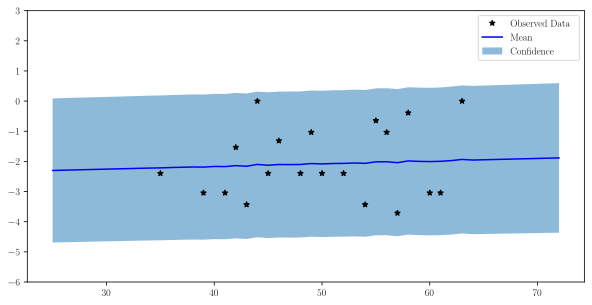

In [23]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_general.numpy(), Y_general.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_general.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_general.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

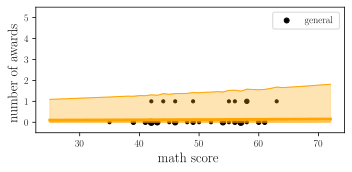

In [24]:
general_mean = np.exp(observed_pred.mean.numpy())
lb_general, ub_general = observed_pred.confidence_region()
lb_general, ub_general = np.exp(lb_general), np.exp(ub_general)

fig = plt.figure(figsize=(5, 2.5), dpi=300)

plt.ylim(-0.5, 5.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_general_scatter_df['math'], poisson_general_scatter_df['num_awards'],
            s=10* poisson_general_scatter_df['count'], color='black', label='general')
plt.plot(x_general, general_mean, lw=3, color='orange')
plt.plot(x_general, ub_general, lw=1, color='orange')
plt.plot(x_general, lb_general, lw=1, color='orange')
plt.fill_between(x_general, lb_general, ub_general, alpha=0.3, color='orange')
plt.legend()

plt.tight_layout()

plt.savefig('general_GP.pdf')

plt.plot();

### For academic

In [25]:
poisson_academic_scatter_df = poisson_academic_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_academic_scatter_df.head(5)

,math,num_awards,count
0,38,0,1
1,41,0,1
2,41,1,1
3,42,0,1
4,43,0,3


In [26]:
X_academic = torch.tensor(poisson_academic_combined_df['math'])
Y_academic = torch.tensor(poisson_academic_combined_df['mu']).float()

x_academic = torch.tensor(np.array(range(X_academic.min() - 10, X_academic.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_academic_combined_df['sigma2'].values)))
model = ExactGPModel(X_academic.view(-1,1), Y_academic, likelihood)

# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_academic.view(-1,1).long())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_academic)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    #"""
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.kernels[0].lengthscale.item(),
        model.likelihood.noise.item()
    ))
    #"""
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_academic))

Iter 1/50 - Loss: 1.641   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.616   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.594   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.574   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 1.556   lengthscale: 0.910   noise: 0.514
Iter 6/50 - Loss: 1.541   lengthscale: 0.967   noise: 0.476
Iter 7/50 - Loss: 1.529   lengthscale: 1.025   noise: 0.442
Iter 8/50 - Loss: 1.520   lengthscale: 1.080   noise: 0.414
Iter 9/50 - Loss: 1.513   lengthscale: 1.133   noise: 0.393
Iter 10/50 - Loss: 1.507   lengthscale: 1.181   noise: 0.380
Iter 11/50 - Loss: 1.501   lengthscale: 1.224   noise: 0.374
Iter 12/50 - Loss: 1.494   lengthscale: 1.261   noise: 0.375
Iter 13/50 - Loss: 1.487   lengthscale: 1.291   noise: 0.381
Iter 14/50 - Loss: 1.480   lengthscale: 1.317   noise: 0.391
Iter 15/50 - Loss: 1.473   lengthscale: 1.338   noise: 0.405
Iter 16/50 - Loss: 1.466   lengthscale: 1.356   noise: 0.421
Iter 17/50 - Loss: 1.459   length

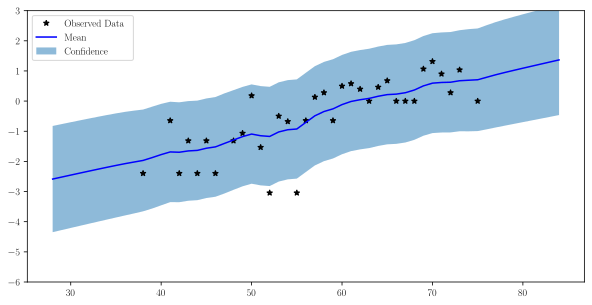

In [27]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_academic.numpy(), Y_academic.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_academic.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_academic.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

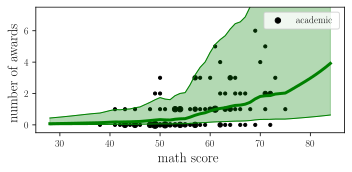

In [28]:
academic_mean = np.exp(observed_pred.mean.numpy())
lb_academic, ub_academic = observed_pred.confidence_region()
lb_academic, ub_academic = np.exp(lb_academic), np.exp(ub_academic)

fig = plt.figure(figsize=(5, 2.5), dpi=300)

plt.ylim(-0.5, 7.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_academic_scatter_df['math'], poisson_academic_scatter_df['num_awards'],
            s=10* poisson_academic_scatter_df['count'], color='black', label='academic')
plt.plot(x_academic, academic_mean, lw=3, color='green')
plt.plot(x_academic, ub_academic, lw=1, color='green')
plt.plot(x_academic, lb_academic, lw=1, color='green')
plt.fill_between(x_academic, lb_academic, ub_academic, alpha=0.3, color='green')
plt.legend()

plt.tight_layout()

plt.savefig('academic_GP.pdf')

plt.plot();

## Redo the same for vocational

In [29]:
poisson_vocational_scatter_df = poisson_vocational_df.groupby(['math', 'num_awards']).size().reset_index(name="count")
poisson_vocational_scatter_df.head(5)

,math,num_awards,count
0,33,0,1
1,37,0,1
2,38,0,1
3,39,0,3
4,39,1,1


In [30]:
X_vocational = torch.tensor(poisson_vocational_combined_df['math'])
Y_vocational = torch.tensor(poisson_vocational_combined_df['mu']).float()

x_vocational = torch.tensor(np.array(range(X_vocational.min() - 10, X_vocational.max() + 10)))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.tensor(np.sqrt(poisson_vocational_combined_df['sigma2'].values)))
model = ExactGPModel(X_vocational.view(-1,1), Y_vocational, likelihood)

# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_vocational.view(-1,1).long())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_vocational)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    #"""
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.kernels[0].lengthscale.item(),
        model.likelihood.noise.item()
    ))
    #"""
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_vocational))

Iter 1/50 - Loss: 1.878   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.857   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 1.842   lengthscale: 0.798   noise: 0.795
Iter 4/50 - Loss: 1.829   lengthscale: 0.854   noise: 0.839
Iter 5/50 - Loss: 1.819   lengthscale: 0.912   noise: 0.869
Iter 6/50 - Loss: 1.809   lengthscale: 0.972   noise: 0.884
Iter 7/50 - Loss: 1.800   lengthscale: 1.033   noise: 0.883
Iter 8/50 - Loss: 1.791   lengthscale: 1.096   noise: 0.871
Iter 9/50 - Loss: 1.782   lengthscale: 1.160   noise: 0.851
Iter 10/50 - Loss: 1.773   lengthscale: 1.223   noise: 0.827
Iter 11/50 - Loss: 1.766   lengthscale: 1.286   noise: 0.801
Iter 12/50 - Loss: 1.759   lengthscale: 1.347   noise: 0.776
Iter 13/50 - Loss: 1.753   lengthscale: 1.405   noise: 0.754
Iter 14/50 - Loss: 1.747   lengthscale: 1.459   noise: 0.739
Iter 15/50 - Loss: 1.742   lengthscale: 1.508   noise: 0.731
Iter 16/50 - Loss: 1.737   lengthscale: 1.552   noise: 0.731
Iter 17/50 - Loss: 1.732   length

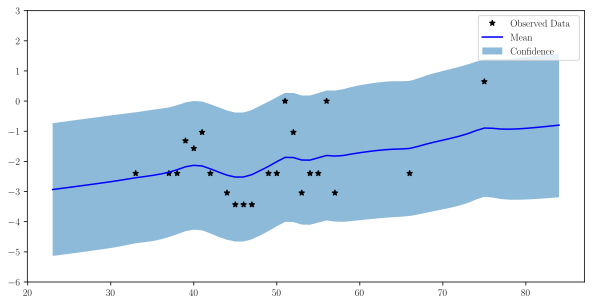

In [31]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_vocational.numpy(), Y_vocational.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_vocational.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_vocational.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-6, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    

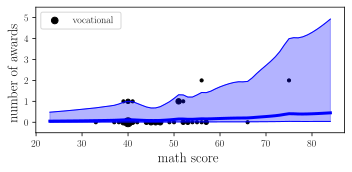

In [32]:
vocational_mean = np.exp(observed_pred.mean.numpy())
lb_vocational, ub_vocational = observed_pred.confidence_region()
lb_vocational, ub_vocational = np.exp(lb_vocational), np.exp(ub_vocational)

fig = plt.figure(figsize=(5, 2.5), dpi=300)

plt.ylim(-0.5, 5.5)
plt.ylabel('number of awards', size=14)
plt.xlabel('math score', size=14)
plt.scatter(poisson_vocational_scatter_df['math'], poisson_vocational_scatter_df['num_awards'],
            s=10* poisson_vocational_scatter_df['count'], color='black', label='vocational')
plt.plot(x_vocational, vocational_mean, lw=3, color='blue')
plt.plot(x_vocational, ub_vocational, lw=1, color='blue')
plt.plot(x_vocational, lb_vocational, lw=1, color='blue')
plt.fill_between(x_vocational, lb_vocational, ub_vocational, alpha=0.3, color='blue')
plt.legend()

plt.tight_layout()

plt.savefig('vocational_GP.pdf')

plt.plot();